## Different imports and setup

In [14]:
# Standard import
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
%matplotlib widget

In [15]:
# Machine learning libraries
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from tqdm.keras import TqdmCallback

In [16]:
# Custom plots file and tensorflow models
from Tools import Plot
from Tools import Custom_models
from Tools import Helpers

## Define the grid and the real solution

In [17]:
N = 100
h = 1/(N-1)

x = np.linspace(0,1,N)
u = 1/2*(1 + np.tanh(50*(x-1/3))) - 1/2*(1 + np.tanh(50*(x-2/3)))  # Function we want to approximate

## Create exact finite element weights 

In [18]:
core1 = np.ones(N)
bias1 = -x

In [19]:
core2 = np.zeros(N)
for i in range(2,N-2):
    core2[i] = 1/h*(u[i-1] - 2*u[i] + u[i+1])
core2[0] = u[1]/h
core2[1] = 1/h*(-2*u[1] + u[2])
core2[N-2] = 1/h*(u[N-3] - 2*u[N-2])
core2[N-1] = u[N-2]/h

bias2 = np.array([0])

In [20]:
core1 = np.expand_dims(core1, axis=0)
core2 = np.expand_dims(core2, axis=1)

In [21]:
weights1_exact = [core1, bias1]
weights2_exact = [core2, bias2]

## Set the seeds and extract the training data

In [22]:
# Set the seed for reproducibility
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed*2)

In [23]:
# Load the data
features_training, labels_training, features_testing, labels_testing = Helpers.Load_and_split_1D('Data/tanh_k50.txt',
                                                                                                 seed, ratio=0.9)

## Slightly modify the exact weights with Gaussian noise

In [ ]:
rng = default_rng(seed=seed)
std = 0.00001
core1_rand = core1 + std*rng.standard_normal(core1.shape)
bias1_rand = bias1 + std*rng.standard_normal(bias1.shape)
core2_rand = core2 + std*rng.standard_normal(core2.shape)
bias2_rand = bias2 + std*rng.standard_normal(bias2.shape)

In [ ]:
weights1_rand = [core1_rand, bias1_rand]
weights2_rand = [core2_rand, bias2_rand]

## Create a model with the modified weights 

In [41]:
model = Custom_models.Model_1D_1_layer(K1=N, K_output=1, name='Exact_FEM_weights_N_100_tanh_k50')
model.build((None, 1))
model.get_layer(name='dense1').set_weights(weights1_exact)
model.get_layer(name='dense2').set_weights(weights2_exact)
model.summary()

Model: "Exact_FEM_weights_N_100_tanh_k50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               multiple                  200       
_________________________________________________________________
dense2 (Dense)               multiple                  101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [42]:
learning_rate = 1e-2
opt = Adam(learning_rate=learning_rate)

model.compile(loss=MeanSquaredError(), optimizer=opt)

In [43]:
# Train
N_epochs = 20

history = model.fit(features_training, labels_training, epochs=N_epochs, validation_split=0.1, verbose=0,
                    shuffle=True, initial_epoch=0, callbacks=[TqdmCallback()])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

## Check the efficiency of training

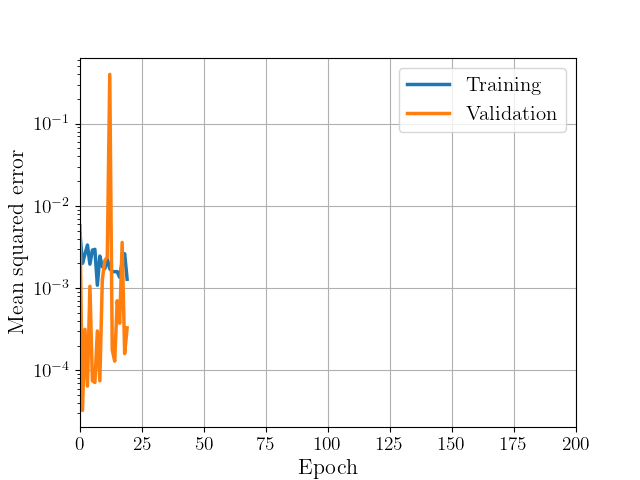

In [44]:
filename = 'Figures/Exact_FEM_N_100_training_error.pdf'
save = False

plt.figure()
plt.semilogy(history.epoch, np.array(history.history['loss']), label='Training')
plt.semilogy(history.epoch, np.array(history.history['val_loss']), label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.xlim([0,200])
plt.legend()
plt.grid()
plt.show()
if (save):
    plt.savefig(filename, bbox_inches='tight')

## Save the model

In [45]:
# Save the model
model_name = 'Saved_models/Exact_FEM_N_100_trained_20'
save_model = False

if (save_model):
    model.save(model_name)

INFO:tensorflow:Assets written to: Saved_models/Exact_FEM_N_100_trained_20/assets


## Check the results on the testing set

In [46]:
sorting = np.argsort(features_testing)
features_testing = features_testing[sorting]
labels_testing = labels_testing[sorting]

prediction = model.predict(features_testing)
prediction = np.ravel(prediction)

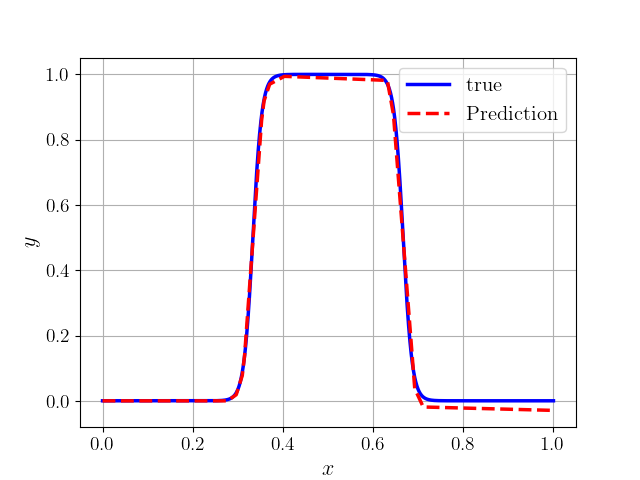

In [47]:
plt.figure()
plt.plot(features_testing, labels_testing, 'b-', label='true')
plt.plot(features_testing, prediction, 'r--', label='Prediction')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.grid()

## Retrieve the weights and assess the difference with the exact weights

In [ ]:
weights1_after_train = model.get_layer(name='dense1').get_weights()
weights2_after_train = model.get_layer(name='dense2').get_weights()

In [ ]:
core1_after_train = weights1_after_train[0]
bias1_after_train = weights1_after_train[1]
core2_after_train = weights2_after_train[0]
bias2_after_train = weights2_after_train[1]

In [ ]:
bias1 - bias1_after_train